The goal of the project is to simultaneously predict keypoints and age of the person in the image. This can be later combined with bounding box detection of a person or having multiple instances in the heatmaps.

## Init

### Libraries

In [2]:
from collections import Counter
from matplotlib import pyplot as plt
import seaborn as sns
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torchvision.models as models
import torchvision.io as io
import torch.nn.functional as F 
from PIL import Image
import gc
import cv2
from ultralytics import YOLO

### Const

In [12]:
NUM_KEYPOINTS = 17
NUM_AGE_CLASSES = 2 #adult vs child, adult(1), child(0), no detection(-1), infant in the future (2), 
IMAGE_SIZE = (256, 192)
HEATMAP_SIZE = (32,24)#(8,6)#(64, 48)
B = 1
C = 2 #how important is age to the loss
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
with open("./data/temp_config.json") as json_conf:
    CONF = json.load(json_conf)


## Helpers

### Functions

In [6]:
def gaussian_2d(shape:tuple, center:tuple, sigma:int=2)->torch.Tensor:
    """Gaussian formula for smoothing/blurring
    sigma is used because shape is circular
    some versions use sigma_x, sigma_y for ellipsis

    Args:
        shape (tuple): heatmap size (h,w)
        center (tuple): coordinates (x,y)
        sigma (int, optional): parameter Defaults to 2.

    Returns:
        torch.Tensor: heatmap
    """
    h, w = shape
    y = torch.arange(0,h).float()
    x = torch.arange(0,w).float()
    yy, xx = torch.meshgrid(y,x,indexing="ij")
    x0, y0 = center
    return torch.exp(-((xx-x0)**2+(yy-y0)**2)/(2*sigma**2))

def kps_to_heatmaps(kps:torch.Tensor, nr_kps:int = NUM_KEYPOINTS, 
                    ht_size:tuple = HEATMAP_SIZE,img_size:tuple = IMAGE_SIZE,th:int=0)-> dict:
    """Converts keypoints of one person to a dictionary of heatmaps (one per keypoint)

    Args:
        kps (torch.Tensor): person's keypoints NUM_KEYPOINTS*3
        nr_kps (int, optional): number of keypoints. Defaults to NUM_KEYPOINTS.
        ht_size (int, optional): size of the heatmap. Defaults to HEATMAP_SIZE.
        th (int, optional): threshold when keypoints are considered. Defaults to 0.

    Returns:
        dict: dictionary of heatmaps, with one per keypoint (x,y)
    """
    ht = torch.zeros(nr_kps, *ht_size)
    ratio_x = ht_size[1] / img_size[1]
    ratio_y = ht_size[0] / img_size[0]
    for k in range(nr_kps):
        x, y, _ = kps[k*3:k*3+3]
        x = x * ratio_x#ht_size[1]
        y = y * ratio_y#ht_size[0]

        ht[k] = gaussian_2d(
            ht_size, center=(x,y),sigma=2
        )
    return ht

def one_person_heatmaps_to_kps(hts:dict,img_size:tuple=IMAGE_SIZE, ht_size:tuple=HEATMAP_SIZE, th:int=0)->list:
    """Converts heatmaps of one person to keypoints
       Each keypoint has (x,y,conf) where conf=2 means it is visible, conf=0 it was not detected

    Args:
        hts (dict): heatmaps
        img_size (tuple, optional): size of the image. Defaults to IMAGE_SIZE.
        ht_size (tuple, optional): _size/dimensions of the image. Defaults to HEATMAP_SIZE.
        th (int, optional):threshold. Defaults to 0.

    Returns:
        list: list of keypoints
    """
    k_nr, ht_h, ht_w = hts.shape
    img_w, img_h = img_size
    kps = []
    for k in range(k_nr):
        temp = hts[k]
        if temp.max() <= th:
            kps.extend([0,0,0])
            continue
        #resize
        idx = temp.argmax()
        x_img = (idx.item() % ht_w) * img_w/ht_w
        y_img = (idx.item() // ht_w) * img_h/ht_h
        kps.extend([x_img,y_img,2])
    return kps

def people_heatmaps_to_kps(ht)->list:
    """Converts heatmaps of multiple people to keypoints

    Args:
        ht (_type_): _description_

    Returns:
        list: list of keypoints
    """
    N, _, _, _ = ht.shape
    all_keypoints = []
    for n in range(N):
        all_keypoints.extend(one_person_heatmaps_to_kps(ht[n]))
    return all_keypoints

def ht_to_coord(ht, topk:int=17)->torch.Tensor:
    """Converts heatmap to coordinates. Softmax is used to normalize the heatmaps

    Args:
        ht (_type_): heatmap
        topk (int, optional): _description_. Defaults to 17.

    Returns:
        torch.Tensor: coordinates
    """
    N, C, H, W = ht.shape
    score, index = ht.view(N,C,1,-1).topk(topk, dim=-1)
    coord = torch.cat([index%W, index//H], dim=2)
    return (coord*F.softmax(score, dim=-1)).sum(-1)

def load_data(ann, label_keys, th:int)->list:
    """Loads data as a list of dictionaries
    Removes duplicates - only images where one person is detected are used
    Only images with age label are used.

    Args:
        ann (dict): annotations
        label_keys (dict_keys): age label
        th (int):min number of keypoints

    Returns:
        list: data with annotations
    """
    data = [a for a in ann if a['num_keypoints'] > th and a['image_id'] in label_keys]
    counts = Counter(d['image_id'] for d in data)
    data = [d for d in data if counts[d['image_id']]==1]
    print(f"Annotations:{len(data)}")
    return data

### Classes

In [7]:
class InputDataset(Dataset):
    def __init__(self, ann_path:str, data_dir:str, label_path:str,th:int=0,is_gag:bool=False):
        self.data_dir = data_dir
        with open(ann_path, "r" ) as f:
            ann = json.load(f)
        self.labels = pd.read_csv(label_path).set_index('image_id').T.to_dict()
        self.data = load_data(ann['annotations'], self.labels.keys(), th)
        self.id_to_name_map = {
            img['id'] : img['file_name']
            for img in ann['images']
        }
        self.is_gag = is_gag
        self.transform = T.Compose([
            T.Resize(IMAGE_SIZE),
            T.ToTensor(),
            T.Normalize(mean=[0.485,0.456,0.406],
                        std=[0.229,0.224,0.225])
        ])
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        kp = self.data[index]
        img_id = kp['image_id']
        img_path = os.path.join(
            self.data_dir,
            self.id_to_name_map[img_id]
        )
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        kps = torch.tensor(kp['keypoints']).float()
        ht = kps_to_heatmaps(kps)
        age = torch.tensor(int(self.labels[img_id]['age']=='adult'), dtype=torch.int64)        
        return image, ht, age
    

class MixedModel(nn.Module):
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.backbone = nn.Sequential(*list(resnet.children())[:-2])#removes classification
        self.pose_head = nn.Sequential(
            nn.Conv2d(2048,256,3,padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(256, 256, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256,NUM_KEYPOINTS,1)
        )
        self.age_head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(2048,256),
            nn.ReLU(inplace=True),
            nn.Linear(256, NUM_AGE_CLASSES)
        )

    def forward(self, x):
        feat = self.backbone(x)
        ht = self.pose_head(feat)
        age = self.age_head(feat)
        return ht, age

## Training

### Helper Functions

In [ ]:
def train_epochs(model:MixedModel, epochs:int, loader:DataLoader, optimizer, scheduler, 
                 pose_criterion, age_criterion, device:str=DEVICE,
                 path:str=CONF['default_model_path'], save_model=True,
                 step_print:bool=True, 
                 th:int=0.25, B:int=1,C:int=2):
    """Train the model for `epochs`. Save model in the given `path`

    Args:
        model (MixedModel): _description_
        epochs (int): _description_
        loader (DataLoader): _description_
        optimizer (_type_): _description_
        scheduler (_type_): _description_
        pose_criterion (_type_): _description_
        age_criterion (_type_): _description_
        device (str, optional): _description_. Defaults to DEVICE.
        path (str, optional): _description_. Defaults to './model_heatmap.pth'.
    """
    for e in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0
        for images, gt_heatmaps, age_labels in loader:
            optimizer.zero_grad()
            images = images.to(device)
            gt_heatmaps = gt_heatmaps.to(device)
            pred_heatmaps, pred_age = model(images)
            loss_pose = pose_criterion(pred_heatmaps, gt_heatmaps)
            loss = loss_pose
            age_labels = age_labels.to(device)
            loss_age = age_criterion(pred_age, age_labels)
            loss = B * loss + C * loss_age            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
        scheduler.step()
        epoch_loss = round(total_loss / num_batches,4)
        lr = round(scheduler.get_last_lr()[0],4)
        print(f"Epoch {e}: loss = {epoch_loss:.4f} lr = {lr}")
        if save_model and step_print and epoch_loss < th:
            torch.save(model.state_dict(),f'{CONF['model_dir']}/model_train_heatmap_{epoch_loss}loss_{e}_{epochs}ep_{lr}lr_Adam_OneCycleLR.pth')
    if save_model:
        torch.save(model.state_dict(), path)  
    return epoch_loss

* MSELoss ranges from $0$ to $1$
* CrossEntropyLoss (for two classes, `adult` and `child`) ranges from $0$ to $0.693$ 
  
The final loss formula is `B * pose_loss + C * age_loss` where $C$ is a constant

I decided to make $B$ equal to $1$ and $C$ equal to $2$ since age is really imporant in this model

The final loss ranges from $0$ to $2.386$ with good values of loss being less than $0.24$ (scaled to 0-1)

In [6]:
pose_criterion = nn.MSELoss(reduction='mean') #normalize heatmap, good especially for large heatmaps
age_criterion = nn.CrossEntropyLoss()

* `keypoints_path` - json from coco website with information. It has `annotations` where each annotation has the `keypoints`, `num_keypoints`, `image_id`, `id` and `images` with `filename` and other information about the images.
* `img_dir` - directory with jpg images from `keypoints_path` json
* `label_path` - path to a csv. The ages were predicted using both the body ratios (MMU gag dataset) and captions from coco dataset, then manually verified by looking through images. Csv has three columns `age` (child|adult), `image_id` (filename), `id`
* `lr` - learning rate chosen using optuna after adding the scheduler
* `epochs` - number of epochs chosen using optuna + verified by saving each model after certain number of epochs
* `opt` - Adam optimizer used for training
* `sch` - OneCycleLR used as a scheduler, the learning rate is annealed until we reach maximum and then we decrease the learning rate lower than the initial learning rate `lr`
* `heatmap` - this version of the model uses heatmaps while predicting

In [ ]:
lr = 0.001
epochs = 10
opt = "Adam"
sch = "OneCycleLR"
ht = "heatmap"

path = f'{CONF['model_dir']}model_train_{ht}_lr{lr}_ep{epochs}_opt{opt}_sch{sch}.pth'

train_data = InputDataset(CONF['train_keypoints_path'],CONF['train_img_dir'], CONF['train_label_path'])
train_loader = DataLoader(train_data, batch_size=64, num_workers=0,pin_memory=True, shuffle=True)

Annotations:3096


### Run Training

In [ ]:
if __name__ == '__main__':
    torch.cuda.empty_cache()
    gc.collect() #clears cache bcs sometimes it breaks
    
    model = MixedModel().to(DEVICE)

    #for param in model.backbone.parameters():
    #    param.requires_grad = False

    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr = lr,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs,
                                                pct_start=0.1,
                                                anneal_strategy='cos'
                                                )

    #for p in model.age_head.parameters():
    #    p.requires_grad = False

    # TO DO
    # add backbone freezing, then training, then unfreeze

    epoch_loss = train_epochs(model, epochs, train_loader, optimizer,
                              scheduler, pose_criterion, age_criterion, path=path)

### Optuna study

#### helper functions

In [ ]:
import optuna
from optuna.samplers import TPESampler

def objective(trial)->float:
    """Runs each trial

    Args:
        trial (_type_): _description_

    Returns:
        float: Returns loss when training
    """
    model = MixedModel().to(DEVICE)
    pose_criterion = nn.MSELoss(reduction='mean') #normalize heatmap, good especially for large heatmaps
    age_criterion = nn.CrossEntropyLoss()

    #for p in model.age_head.parameters():
    #    p.requires_grad = False
    # TO DO
    # add backbone freezing, then training, then unfreeze
        
    epochs = trial.suggest_int("epochs",0,100)
    lr = trial.suggest_int("lr",1e-3, 1e-1)
    pct_start = trial.suggest_float("pct_start",0.05, 0.3)
    batch_size = trial.suggest_int("batch_size",2, 256)
    train_data = InputDataset(CONF['train_keypoints_path'],CONF['train_img_dir'], CONF['train_label_path'])
    train_loader = DataLoader(train_data, batch_size=batch_size, num_workers=0, pin_memory=True, shuffle=True)
    optimizer = optim.Adam(model.parameters(), lr)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer,
                                                max_lr = lr,
                                                steps_per_epoch=len(train_loader),
                                                epochs=epochs,
                                                pct_start=pct_start,
                                                anneal_strategy='cos'
                                                )
    return train_epochs(model, epochs, train_loader, optimizer, scheduler, pose_criterion, age_criterion, save_model=False, step_print=False)
    # model.fit(X_train, y_train)
    # y_pred = model.predict(X_test)
    # return accuracy_score(y_test, y_pred)
    #TO DO
    # add accuracy of age and separately for heatmaps/keypoints


optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)

study = optuna.create_study(study_name="coco", direction="minimize", sampler=sampler)
study.optimize(objective, n_trials=100)

## Validation

Helper function

In [133]:
def run_test(model:MixedModel, loader:DataLoader,
                 pose_criterion, age_criterion, device:str=DEVICE,
                 B:int=1, C:int=2)->tuple[list,list,list, list]:
    """ Predict for all data in the test loader

    Args:
        model (MixedModel): _description_
        epochs (int): _description_
        loader (DataLoader): _description_
        pose_criterion (_type_): _description_
        age_criterion (_type_): _description_
        device (str, optional): _description_. Defaults to DEVICE.
        path (str, optional): _description_. Defaults to './model_heatmap.pth'.   
    Returns:
        tuple[list,list]: returns two lists of keypoints, one extracted normally and one softmaxed, 
        one list with age, one list with heatmaps
    """
    kps = []
    kps2 = []
    age = []
    ht = []
    total_loss = 0.0
    total_age_loss = 0.0
    total_kp_loss = 0.0
    num_batches = 0
    model.eval()
    with torch.no_grad():
        for images, gt_heatmaps, age_labels in loader:
                images = images.to(device)
                gt_heatmaps = gt_heatmaps.to(device)
                #plt.figure(figsize=(4,3))
                #sns.heatmap(gt_heatmaps[0][0].cpu(), cmap="crest")
                #plt.show()
                #plt.close()
                pred_heatmaps, pred_age = model(images)
                ht.extend(pred_heatmaps)
                kps.extend(people_heatmaps_to_kps(pred_heatmaps))
                kps2.extend(ht_to_coord(pred_heatmaps))
                loss_pose = pose_criterion(pred_heatmaps, gt_heatmaps)
                total_kp_loss += loss_pose.item()
                loss = loss_pose
                age_labels = age_labels.to(DEVICE)
                loss_age = age_criterion(pred_age, age_labels)
                loss = B * loss + C * loss_age
                total_age_loss += loss_age.item()
                pred_age = pred_age.to(dtype=torch.int64)
                age.extend(pred_age)
                total_loss += loss.item()
                num_batches += 1
        print(f"Testing loss = {total_loss / num_batches:.4f}. Age = {total_age_loss/num_batches:.4f} Kp = {total_kp_loss/num_batches:.4f}")
    return kps, kps2, age, ht

Load Test/Validation Data

In [14]:
val_data = InputDataset(CONF['val_keypoints_path'],CONF['val_img_dir'], CONF['val_label_path'])
val_loader = DataLoader(val_data, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
pose_criterion = nn.MSELoss(reduction='mean') #normalize heatmap, good especially for large heatmaps
age_criterion = nn.CrossEntropyLoss()

Annotations:1232


In [134]:
if __name__ == '__main__':
    torch.cuda.empty_cache()
    gc.collect() #clears cache bcs sometimes it breaks
    model_path = CONF['best_model']
    
    model = MixedModel().to(DEVICE)
    model.load_state_dict(torch.load(model_path, map_location=DEVICE, weights_only=True))
    
    kps, soft_kps, age, ht = run_test(model, val_loader, pose_criterion, age_criterion)

Testing loss = 1.4616. Age = 0.7296 Kp = 0.0024


## Visualisation

In [160]:
val_data.data[0]['image_id']

286813

In [159]:
val_data.__getitem__(0)[2] == age[0].argmax()

tensor(True, device='cuda:0')

<Axes: >

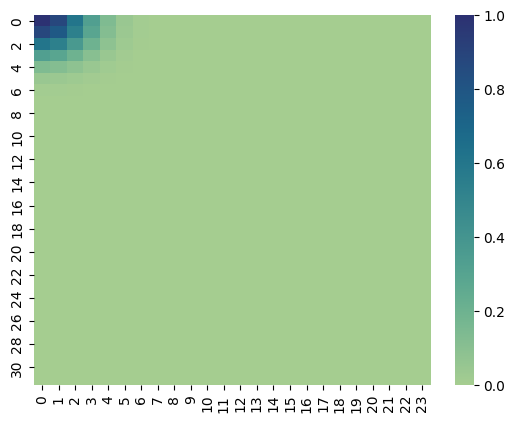

In [171]:
sns.heatmap(val_data.__getitem__(0)[1][3].cpu(), cmap="crest")

<Axes: >

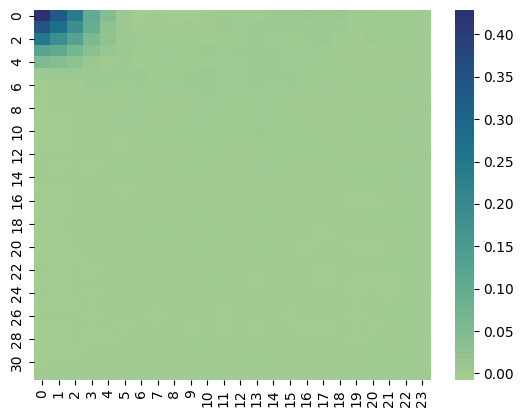

In [172]:
sns.heatmap(ht[0][3].cpu(), cmap="crest")

In [136]:
np.reshape(val_data.data[1]['keypoints'], (-1,3))

array([[298, 161,   2],
       [314, 152,   2],
       [289, 147,   2],
       [344, 104,   2],
       [278,  96,   2],
       [368, 134,   2],
       [197, 132,   2],
       [380, 251,   2],
       [170, 249,   2],
       [316, 314,   2],
       [240, 290,   2],
       [323, 374,   2],
       [231, 377,   2],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0],
       [  0,   0,   0]])

In [158]:
#np.reshape(kps,(-1,3))

<Axes: >

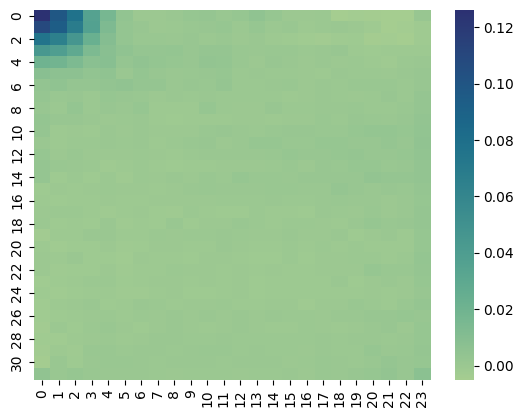

In [83]:
sns.heatmap(ht[0][0].cpu(), cmap="crest")

## Run on real videos

The plan is to track people and get the boxes and detect keypoints+age on the cropped images. The issue is occlusion and people leaving and reappearing in the view.

TO DO: combine permanent id tracking, saving the ids for some time and reid (current version has iding based on ratios which is not memory efficient)

In [ ]:
def save_boxes(vid_path:str, box_path:str, track_path:str, out_dir:str, device:str=DEVICE)->list:
    """Detect and save boxes"""
    box_model = YOLO(box_path)
    box_model.to(device)
    try:
        cap = cv2.VideoCapture(vid_path)
    except:
        print("No video")
        return

    os.makedirs(out_dir,exist_ok=True)

    frame_nr = 0
    boxes = []

    results = box_model.track(
            source=vid_path,
            classes=[0],
            persist=True,
            verbose=False,
            show=False, 
            tracker=track_path,
            stream=True
        )
    for r in results:
        frame_nr += 1
        if len(r.boxes)==0:
            continue
        frame = r.orig_img
        width, height, _ = frame.shape
        boxes_xyxy = r.boxes.xyxy.cpu().numpy().astype(int)
        tracker_ids = (r.boxes.id.int().cpu().numpy().astype(int)
                       if r.boxes.id is not None
                       else [-1] * len(boxes)
                       )
        for b, t in zip(boxes_xyxy, tracker_ids):
            x1,y1,x2,y2 = map(int,b)
            x1, y1,x2,y2 = max(0,x1),max(0,y1),min(width,x2),min(height,y2)
            boxes.append({
                'frame_nr':frame_nr,
                'id': t,
                'bbox':(x1,y1,x2,y2)
            })
            cv2.imwrite(f"{out_dir}frame_{frame_nr}_id_{t}.jpg",frame[y1:y2,x1:x2])
    cap.release()
    cv2.destroyAllWindows()
    return boxes

In [25]:
boxes = save_boxes(CONF['video_path'],CONF["box_model"],CONF["tracking"],CONF['crops_dir'])

boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1440, 3)
boxes:2
(1080, 1

In [ ]:
import csv
import cv2
from ultralytics import YOLO

keypoint_names = [
"nose","left_eye", "right_eye", "left_ear", "right_ear", "left_shoulder", "right_shoulder","left_elbow", "right_elbow",
"left_wrist", "right_wrist", "left_hip", "right_hip", "left_knee", "right_knee","left_ankle", "right_ankle"
]


def calc_skeleton(kps, conf, frame_number, person_id)->list:
    """Calculate skeleton"""
    kp = np.array(kps)
    c = np.array(conf)
    row = [frame_number,person_id]
    for i, (x, y) in enumerate(kp):
        row.extend([float(x), float(y),float(c[i])])
    return row 

### Run prediction

### Display keypoints

## References

1. [Tutorial on adding another head when predicting](https://y-t-g.github.io/tutorials/yolov8n-add-classes/)
2. [Ultralytics model training](https://docs.ultralytics.com/modes/train/#idle-gpu-training)
3. [Roboflow tutorial](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/train-yolov8-keypoint.ipynb)
4. [Keypoints with heatmaps](https://www.slingacademy.com/article/creating-a-keypoint-detection-model-with-pytorch-and-heatmap-regression/)
5. [Tutorial on keypoints regression, used some heatmap functions](https://elte.me/2021-03-10-keypoint-regression-fastai)
6. [Heatmap transform](https://github.com/baoshengyu/H3R/blob/master/torchalign/heatmap_head/transforms/functional.py)
7. [Heatmap regression via randomized rounding](https://github.com/baoshengyu/H3R)
8. [Frozen layers](https://medium.com/we-talk-data/guide-to-freezing-layers-in-pytorch-best-practices-and-practical-examples-8e644e7a9598)